# DTMC

In [1]:
from switss.model import DTMC
import numpy as np
from switss.utils import color_from_hash

# setup the graph
# ----------------
E = [[0,1],[1,2],[2,0], [2, 1],[3,2],[3,1],[3,5],[4,2],[4,6],[5,4],[5,3],[6,4],[7,5],[7,6],[7,7]]
P = np.zeros(shape=(8,8))
for u,v in E:
    # initialize with arbitrary probabilities
    ucount = len([w for w,z in E if w == u])
    P[u,v] = 1/ucount
# ----------------

# create DTMC
dtmc = DTMC(P)

In [2]:
# get maximal end components from dtmc (input for the certification)
mecs = dtmc.maximal_end_components()

try:
    from switss.certification.mec_certificates import check_mec_certificate, generate_mec_certificate
    
    mec_certificate = None
    mec_certificate = generate_mec_certificate(dtmc, mecs)

    print("MEC quotient-MPD EC-freeness certificate:")
    print(mec_certificate[0])
    print('\n')

    print("MEC strongly connected certificate:")
    print("fwd:", mec_certificate[1][0])
    print("bwd:", mec_certificate[1][1]) 
    print('\n')
except:
    print("Can not certify the MEC decomposition!")
finally:
    print("MEC certificate is valid:", check_mec_certificate(dtmc, mecs, mec_certificate))

MEC quotient-MPD EC-freeness certificate:
[ 3.2  2.2  3.6  4.   3.   0.  -1. ]


MEC strongly connected certificate:
fwd: [0 2 1 0 0 0 0 0]
bwd: [0 1 2 0 0 0 0 0]


MEC certificate is valid: True


## DTMC (details)

Components: [5 5 5 1 4 2 3 0] Proper MECs: [0 0 0 0 0 1] MECs amount: 6


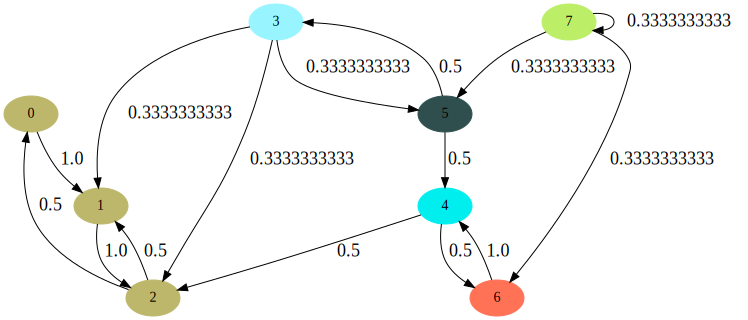

In [3]:
components,proper_mecs,mec_counter = mecs

print("Components:",components,"Proper MECs:",proper_mecs,"MECs amount:",mec_counter)

def sm(stateidx,labels):
    color = color_from_hash(7*components[stateidx])
    return { "color" : color, "style" : "filled" } 

dtmc.digraph(state_map=sm)

In [4]:
# print state-action encoding for the rows in the transition matrix
print("Index by state action: (from_state, action) <-> code")
for (from_state, action), code in dtmc.index_by_state_action.items():
    print(f'({from_state}, {action}) <-> {code}') 
print('\n')

print("Transitions:")
print(dtmc.P)

Index by state action: (from_state, action) <-> code
(0, 0) <-> 0
(1, 0) <-> 1
(2, 0) <-> 2
(3, 0) <-> 3
(4, 0) <-> 4
(5, 0) <-> 5
(6, 0) <-> 6
(7, 0) <-> 7


Transitions:
  (0, 1)	1.0
  (1, 2)	1.0
  (2, 0)	0.5
  (2, 1)	0.5
  (3, 1)	0.3333333333333333
  (3, 2)	0.3333333333333333
  (3, 5)	0.3333333333333333
  (4, 2)	0.5
  (4, 6)	0.5
  (5, 3)	0.5
  (5, 4)	0.5
  (6, 4)	1.0
  (7, 5)	0.3333333333333333
  (7, 6)	0.3333333333333333
  (7, 7)	0.3333333333333333


Component members:
Component 0 = A: [7]
Component 1 = B: [3]
Component 2 = C: [5]
Component 3 = D: [6]
Component 4 = E: [4]
Component 5 = F: [0, 1, 2]


Index by state action:
 (from_component, q_action = original dtmc action code) <-> q_code
(B, 3) <-> 0
(E, 4) <-> 1
(C, 5) <-> 2
(D, 6) <-> 3
(A, 7) <-> 4
(F, 8) <-> 5




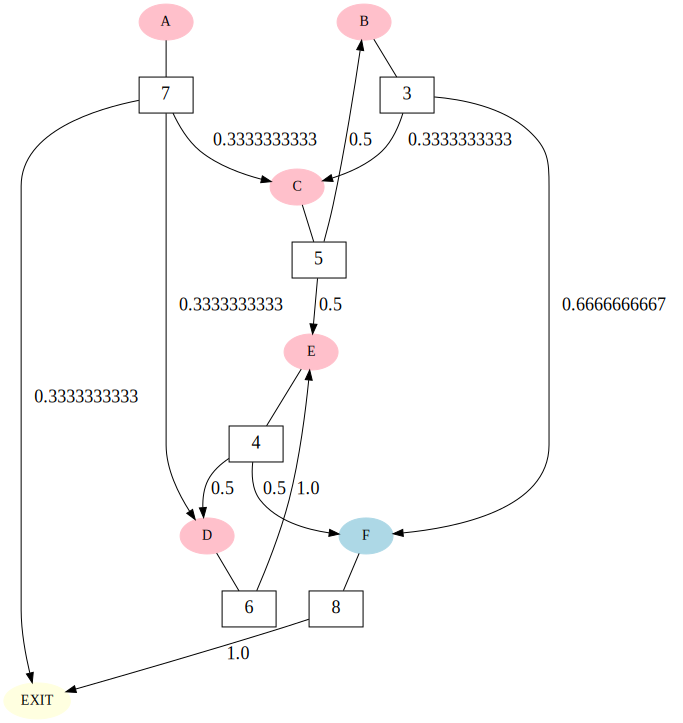

In [5]:
# build mec quotient mdp
q_mdp,original_inner_action_codes = dtmc.mec_quotient_mdp(mecs)

# print the MEC-quotient-MDP (proper MECs are blue)
component_members = {}
for vertex, component in enumerate(components):
    if component not in component_members:
        component_members[component] = []
    component_members[component].append(vertex)

print("Component members:")
for compidx in range(mec_counter):
    print(f'Component {compidx} = {chr(ord('A') + compidx)}:', component_members[compidx])
print('\n')

print("Index by state action:\n (from_component, q_action = original dtmc action code) <-> q_code")
for (from_comp, action), code in q_mdp.index_by_state_action.items():
    print(f'({chr(ord('A') + from_comp)}, {action}) <-> {code}') 
print('\n')

def sm(compidx,labels):
    if compidx == mec_counter:
        color = "lightyellow"
        label = "EXIT"
    elif proper_mecs[compidx] == 1:
        color = "lightblue"
        label = chr(ord('A') + compidx)
    else:
        color = "pink"
        label = chr(ord('A') + compidx)
    return { "color" : color, "style" : "filled", "label" : label } 

q_mdp.digraph(state_map=sm)

In [6]:
from switss.solver import LP

# get system matrix of the MEC quotient MDP
q_A = q_mdp.get_system_matrix()

# constraints count and variables count in the system matrix   
constraints = q_A.shape[0]
variables = q_A.shape[1]
# create matrix for LP from the system matrix and add constrainst for bounding the variables
A = q_A
b = np.array(list(constraints*[1]))
opt = np.array(variables*[0])
# calculate the variables in the certificate for EC=freeness of the quotient mdp
lp = LP.from_coefficients(A,b,opt,sense=">=")
result = lp.solve(solver="gurobi")
mec_quotient_ec_free_cert = result.result_vector

for i in range(A.shape[0]):
    print(A[i], '* z >= ', b[i])
print('\n')
print(result)

print("Multiply system Matrix with the certificate: ")
print(np.matmul(q_A, np.matrix(mec_quotient_ec_free_cert).transpose()))
print('\n')

[ 0.          1.         -0.33333333  0.          0.         -0.66666667
  0.        ] * z >=  1
[ 0.   0.   0.  -0.5  1.  -0.5  0. ] * z >=  1
[ 0.  -0.5  1.   0.  -0.5  0.   0. ] * z >=  1
[ 0.  0.  0.  1. -1.  0.  0.] * z >=  1
[ 1.          0.         -0.33333333 -0.33333333  0.          0.
 -0.33333333] * z >=  1
[ 0.  0.  0.  0.  0.  1. -1.] * z >=  1


SolverResult(status=optimal, result_vector=[-0.4 -1.4  0.   0.4 -0.6 -3.6 -4.6], value=0.0)
Multiply system Matrix with the certificate: 
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]




In [7]:
vertex_count = dtmc.P.shape[1]

adj = {}  # adjacency list, contains only edges from inner actions
rev_adj = {}
for u in range(vertex_count):
    adj[u] = []
    rev_adj[u] = []

original_inner_action_codes = set(original_inner_action_codes)
for code, v_state in list(dtmc.P.keys()):
    if code not in original_inner_action_codes:
        continue
    u_state, action = dtmc.index_by_state_action.inv[code]
    adj[u_state].append(v_state)
    rev_adj[v_state].append(u_state)

print("Adjacency list with only inner actions:")
for u, v_list in adj.items():
    print(u, '->', v_list)
print('\n')

print("Adjacency list (reversed) with only inner actions:")
for u, v_list in rev_adj.items():
    print(u, '->', v_list)

Adjacency list with only inner actions:
0 -> [1]
1 -> [2]
2 -> [0, 1]
3 -> []
4 -> []
5 -> []
6 -> []
7 -> []


Adjacency list (reversed) with only inner actions:
0 -> [2]
1 -> [0, 2]
2 -> [1]
3 -> []
4 -> []
5 -> []
6 -> []
7 -> []


In [8]:
from collections import deque

fwd = np.zeros(vertex_count, dtype=int)
bwd = np.zeros(vertex_count, dtype=int)
processed = np.zeros(vertex_count, dtype=bool)

def bfs(adjacent, source, cb):
    visited = np.zeros(vertex_count, dtype=bool)
    distance = np.zeros(vertex_count, dtype=int)
    queue = deque([source])
    visited[source] = processed[source] = True
    while len(queue) > 0:
        current_vertex = queue.popleft()
        cb(current_vertex, distance[current_vertex])
        for next_vertex in adjacent[current_vertex]:
            if visited[next_vertex]:
                continue
            visited[next_vertex] = processed[next_vertex] = True
            distance[next_vertex] = distance[current_vertex] + 1
            queue.append(next_vertex)

def set_fwd(vertex, dist):
    fwd[vertex] = dist

def set_bwd(vertex, dist):
    bwd[vertex] = dist

for u in range(vertex_count):
    if processed[u]:
        continue
    bfs(adj, u, set_bwd)
    bfs(rev_adj, u, set_fwd)

print("fwd:", fwd)
print("bwd:", bwd) 

fwd: [0 2 1 0 0 0 0 0]
bwd: [0 1 2 0 0 0 0 0]


### Check the certificate (fwd, bwd) for MECs begin strongly connected according to lemma 3.27

The check of the certificate for MEC-decomposition quotient-MDP being EC-free proves that each state belongs to exactly one MEC. Use only transitions from EC inner actions so the graph consists of unconnected MECs. Due to this restriction we can assume $fwd, bwd$ are functions: $S \to N$ because there are no edges between MECs.

Iterate through all edges $(u, v)$ in the constructed graph. $u$ and $v$ belong to same MEC, $(u, v)$ is the edge in this MEC. Define functions $fwd_{ok}, bwd_{ok}: S \to \{0, 1\}$, init all function values with 0. Check the lemma constraints 2 and 3:

- if $fwd(v) < fwd(u)$ then $fwd_{ok}(u) := 1$
- if $bwd(u) < bwd(v)$ then $bwd_{ok}(v) := 1$

These constraints can not be fulfiled for MEC-leaders, defined in the lemma constraint 1, since  no other $fwd$ or $bwd$ value can be smaller than 0 value of the MEC-leader. So after checking all edges:
- for all non-leader states $s$ the following must be satisfied: $fwd_{ok}(s) = bwd_{ok}(s) = 1$;
- all MEC-leaders must satisfy: $fwd_{ok}(s) = bwd_{ok}(s) = 0$;

$fwd_{ok}(s)$ and $bwd_{ok}(s)$ are the same functions so we can consider $fwd_{ok}$ as a representative of both.

Now check the lemma constraint 1. Define $L:=\{s \in S | fwd_{ok}(s) = 0 \}$ as the set of MEC-leaders retrieved from $fwd$. By definition each MEC has exactly one leader and each MEC-leader (state) belongs to exactly one component. Henceforth the function $leaders$ must be a bijection: $L \to C, leaders(s) := components(s)$, where $C$ is the set of MECs, $s \in L$, $components$ is a function which assigns a MEC to each state. 
Define $ComponentLeaderCount: C \to N$, $ComponentLeaderCount(c)$ is the amount of $c$ entries in values of $leaders$,in other words $ComponentLeaderCount(c)$ is the amount of MEC-leaders of the MEC $c$. Each $ComponentLeaderCount(c)$ is equal 1 if and if only $leaders$ is a bijection because bijection is one-to-one correspondence between two sets.

This check proves $fwd, bwd$ satisfy all the constraints from the lemma.

In [9]:
vertex_count = dtmc.P.shape[1]
# check fwd, bwd are functions: S -> N
if fwd.shape[0] != vertex_count or bwd.shape[0] != vertex_count:
    print("INVALID")
if not np.issubdtype(fwd.dtype, np.integer) or not np.issubdtype(bwd.dtype, np.integer):
    print("INVALID")
# check fwd and bwd non-leader constraints

fwd_ok = np.zeros(vertex_count, dtype=bool)
bwd_ok = np.zeros(vertex_count, dtype=bool)

for code, v_state in list(dtmc.P.keys()):
    if code not in original_inner_action_codes:
        continue
    u_state, action = dtmc.index_by_state_action.inv[code]
    if fwd[v_state] < fwd[u_state]:
        fwd_ok[u_state] = True
    if bwd[u_state] < bwd[v_state]:
        bwd_ok[v_state] = True
if not np.all(fwd_ok == bwd_ok):  # all elements except of component leaders (bwd[u] = fwd[u] = 0) must be True
    print("INVALID")
# check leaders-components bijection (each component has exactly one leader)
component_leaders = np.zeros(mec_counter, dtype=int)
for state,ok in enumerate(fwd_ok):
    if not ok:  # then state is a leader
        component_leaders[components[state]] += 1
if not (component_leaders == 1).all():
    print("INVALID")


print("fwd_ok:",fwd_ok)
print("bwd_ok:",bwd_ok)
print("ComponentLeaderCount:",component_leaders)

fwd_ok: [False  True  True False False False False False]
bwd_ok: [False  True  True False False False False False]
ComponentLeaderCount: [1 1 1 1 1 1]


# MDP

In [10]:
from switss.model import MDP
import numpy as np
from switss.utils import color_from_hash

# setup the graph
# ----------------
SAPpairs = [(3,0,5,0.2),(3,0,0,0.2),(2,0,1,0.7),(0,0,1,1),(1,0,2,1),(2,0,0,0.3),(3,0,2,0.6),(4,0,2,0.5),(3,1,5,1),(5,1,3,1),(5,0,4,1),(4,0,6,0.5),(6,0,4,1),(7,1,6,0.5),(7,1,5,0.5),(7,0,7,1)]
index_by_state_action = {(0,0):0,(1,0):1,(2,0):2,(3,0):3,(4,0):4,(3,1):5,(5,1):6,(5,0):7,(6,0):8,(7,1):9,(7,0):10}
P = np.zeros(shape=(11,8))
for s,a,d,p in SAPpairs:
    P[index_by_state_action[(s,a)],d] = p
# ----------/------

mdp = MDP(P,index_by_state_action)


In [11]:
# get maximal end components from mdp (input for the certification)
mecs = mdp.maximal_end_components()

try:
    from switss.certification.mec_certificates import check_mec_certificate, generate_mec_certificate

    mec_certificate = generate_mec_certificate(mdp, mecs)

    print("MEC quotient-MPD EC-freeness certificate:")
    print(mec_certificate[0])
    print('\n')

    print("MEC strongly connected certificate:")
    print("fwd:", mec_certificate[1][0])
    print("bwd:", mec_certificate[1][1]) 
    print('\n')
except:
    print("Can not certify the MEC decomposition!")
finally:
    print("MEC certificate is valid:", check_mec_certificate(mdp, mecs, mec_certificate))

MEC quotient-MPD EC-freeness certificate:
[6. 5. 5. 4. 1. 0.]


MEC strongly connected certificate:
fwd: [0 2 1 0 0 1 0 0]
bwd: [0 1 2 0 0 1 0 0]


MEC certificate is valid: True


## MDP (details)

Components: [4 4 4 1 3 1 2 0] Proper MECs: [1 1 0 0 1] MECs amount: 5


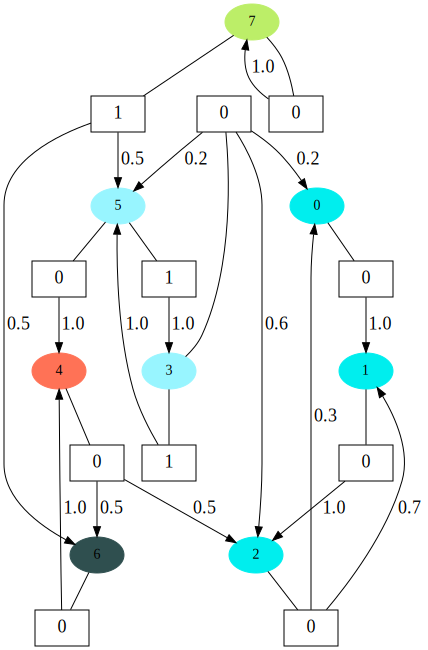

In [12]:
components,proper_mecs,mec_counter = mecs

print("Components:",components,"Proper MECs:",proper_mecs,"MECs amount:",mec_counter)

def sm(stateidx,labels):
    color = color_from_hash(7*components[stateidx])
    return { "color" : color, "style" : "filled" } 

mdp.digraph(state_map=sm)

In [13]:
# print state-action encoding for the rows in the transition matrix
print("Index by state action: (from_state, action) <-> code")
for (from_state, action), code in mdp.index_by_state_action.items():
    print(f'({from_state}, {action}) <-> {code}') 
print('\n')

print("Transitions:")
print(mdp.P)

Index by state action: (from_state, action) <-> code
(0, 0) <-> 0
(1, 0) <-> 1
(2, 0) <-> 2
(3, 0) <-> 3
(4, 0) <-> 4
(3, 1) <-> 5
(5, 1) <-> 6
(5, 0) <-> 7
(6, 0) <-> 8
(7, 1) <-> 9
(7, 0) <-> 10


Transitions:
  (0, 1)	1.0
  (1, 2)	1.0
  (2, 0)	0.3
  (2, 1)	0.7
  (3, 0)	0.2
  (3, 2)	0.6
  (3, 5)	0.2
  (4, 2)	0.5
  (4, 6)	0.5
  (5, 5)	1.0
  (6, 3)	1.0
  (7, 4)	1.0
  (8, 4)	1.0
  (9, 5)	0.5
  (9, 6)	0.5
  (10, 7)	1.0


Component members:
Component 0 = A: [7]
Component 1 = B: [3, 5]
Component 2 = C: [6]
Component 3 = D: [4]
Component 4 = E: [0, 1, 2]


Index by state action:
 (from_component, q_action = original mdp action code) <-> q_code
(B, 3) <-> 0
(D, 4) <-> 1
(B, 7) <-> 2
(C, 8) <-> 3
(A, 9) <-> 4
(A, 11) <-> 5
(B, 11) <-> 6
(E, 11) <-> 7




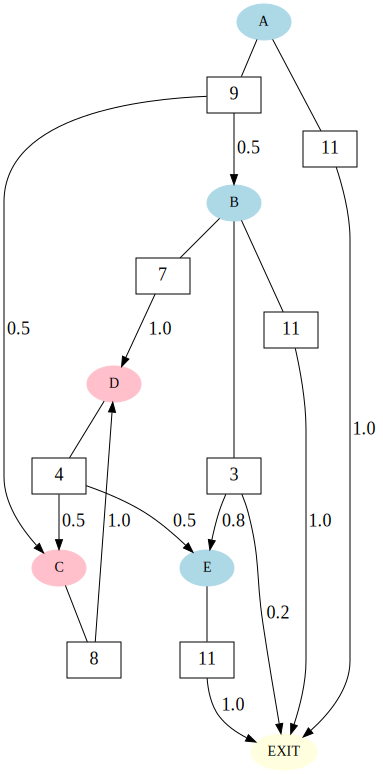

In [14]:
# build mec quotient mdp
q_mdp,original_inner_action_codes = mdp.mec_quotient_mdp(mecs)

# print the MEC-quotient-MDP (proper MECs are blue)
component_members = {}
for vertex, component in enumerate(components):
    if component not in component_members:
        component_members[component] = []
    component_members[component].append(vertex)

print("Component members:")
for compidx in range(mec_counter):
    print(f'Component {compidx} = {chr(ord('A') + compidx)}:', component_members[compidx])
print('\n')

print("Index by state action:\n (from_component, q_action = original mdp action code) <-> q_code")
for (from_comp, action), code in q_mdp.index_by_state_action.items():
    print(f'({chr(ord('A') + from_comp)}, {action}) <-> {code}') 
print('\n')

def sm(compidx,labels):
    if compidx == mec_counter:
        color = "lightyellow"
        label = "EXIT"
    elif proper_mecs[compidx] == 1:
        color = "lightblue"
        label = chr(ord('A') + compidx)
    else:
        color = "pink"
        label = chr(ord('A') + compidx)
    return { "color" : color, "style" : "filled", "label" : label } 

q_mdp.digraph(state_map=sm)

In [15]:
from switss.solver import LP

# get system matrix of the MEC quotient MDP
q_A = q_mdp.get_system_matrix()

# constraints count and variables count in the system matrix   
constraints = q_A.shape[0]
variables = q_A.shape[1]
# create matrix for LP from the system matrix and add constrainst for bounding the variables
A = q_A
b = np.array(list(constraints*[1]))
opt = np.array(variables*[0])
# calculate the variables in the certificate for EC=freeness of the quotient mdp
lp = LP.from_coefficients(A,b,opt,sense=">=")
result = lp.solve(solver="gurobi")
mec_quotient_ec_free_cert = result.result_vector

for i in range(A.shape[0]):
    print(A[i], '* z >= ', b[i])
print('\n')
print(result)

print("Multiply system Matrix with the certificate: ")
print(np.matmul(q_A, np.matrix(mec_quotient_ec_free_cert).transpose()))
print('\n')

[ 0.   1.   0.   0.  -0.8 -0.2] * z >=  1
[ 0.   0.  -0.5  1.  -0.5  0. ] * z >=  1
[ 0.  1.  0. -1.  0.  0.] * z >=  1
[ 0.  0.  1. -1.  0.  0.] * z >=  1
[ 1.  -0.5 -0.5  0.   0.   0. ] * z >=  1
[ 1.  0.  0.  0.  0. -1.] * z >=  1
[ 0.  1.  0.  0.  0. -1.] * z >=  1
[ 0.  0.  0.  0.  1. -1.] * z >=  1


SolverResult(status=optimal, result_vector=[ 2.  1.  1.  0. -3. -4.], value=0.0)
Multiply system Matrix with the certificate: 
[[4.2]
 [1. ]
 [1. ]
 [1. ]
 [1. ]
 [6. ]
 [5. ]
 [1. ]]




In [16]:
vertex_count = mdp.P.shape[1]

adj = {}  # adjacency list, contains only edges from inner actions
rev_adj = {}
for u in range(vertex_count):
    adj[u] = []
    rev_adj[u] = []

original_inner_action_codes = set(original_inner_action_codes)
for code, v_state in list(mdp.P.keys()):
    if code not in original_inner_action_codes:
        continue
    u_state, action = mdp.index_by_state_action.inv[code]
    adj[u_state].append(v_state)
    rev_adj[v_state].append(u_state)

print("Adjacency list with only inner actions:")
for u, v_list in adj.items():
    print(u, '->', v_list)
print('\n')

print("Adjacency list (reversed) with only inner actions:")
for u, v_list in rev_adj.items():
    print(u, '->', v_list)

Adjacency list with only inner actions:
0 -> [1]
1 -> [2]
2 -> [0, 1]
3 -> [5]
4 -> []
5 -> [3]
6 -> []
7 -> [7]


Adjacency list (reversed) with only inner actions:
0 -> [2]
1 -> [0, 2]
2 -> [1]
3 -> [5]
4 -> []
5 -> [3]
6 -> []
7 -> [7]


In [17]:
from collections import deque

fwd = np.zeros(vertex_count, dtype=int)
bwd = np.zeros(vertex_count, dtype=int)
processed = np.zeros(vertex_count, dtype=bool)

def bfs(adjacent, source, cb):
    visited = np.zeros(vertex_count, dtype=bool)
    distance = np.zeros(vertex_count, dtype=int)
    queue = deque([source])
    visited[source] = processed[source] = True
    while len(queue) > 0:
        current_vertex = queue.popleft()
        cb(current_vertex, distance[current_vertex])
        for next_vertex in adjacent[current_vertex]:
            if visited[next_vertex]:
                continue
            visited[next_vertex] = processed[next_vertex] = True
            distance[next_vertex] = distance[current_vertex] + 1
            queue.append(next_vertex)

def set_fwd(vertex, dist):
    fwd[vertex] = dist

def set_bwd(vertex, dist):
    bwd[vertex] = dist

for u in range(vertex_count):
    if processed[u]:
        continue
    bfs(adj, u, set_bwd)
    bfs(rev_adj, u, set_fwd)

print("fwd:", fwd)
print("bwd:", bwd) 

fwd: [0 2 1 0 0 1 0 0]
bwd: [0 1 2 0 0 1 0 0]


In [18]:
vertex_count = mdp.P.shape[1]
# check fwd, bwd are functions: S -> N
if fwd.shape[0] != vertex_count or bwd.shape[0] != vertex_count:
    print("INVALID")
if not np.issubdtype(fwd.dtype, np.integer) or not np.issubdtype(bwd.dtype, np.integer):
    print("INVALID")
# check fwd and bwd non-leader constraints

fwd_ok = np.zeros(vertex_count, dtype=bool)
bwd_ok = np.zeros(vertex_count, dtype=bool)

for code, v_state in list(mdp.P.keys()):
    if code not in original_inner_action_codes:
        continue
    u_state, action = mdp.index_by_state_action.inv[code]
    if fwd[v_state] < fwd[u_state]:
        fwd_ok[u_state] = True
    if bwd[u_state] < bwd[v_state]:
        bwd_ok[v_state] = True
if not np.all(fwd_ok == bwd_ok):  # all elements except of component leaders (bwd[u] = fwd[u] = 0) must be True
    print("INVALID")
# check leaders-components bijection (each component has exactly one leader)
component_leaders = np.zeros(mec_counter, dtype=int)
for state,ok in enumerate(fwd_ok):
    if not ok:  # then state is a leader
        component_leaders[components[state]] += 1
if not (component_leaders == 1).all():
    print("INVALID")


print("fwd_ok:",fwd_ok)
print("bwd_ok:",bwd_ok)
print("ComponentLeaderCount:",component_leaders)

fwd_ok: [False  True  True False False  True False False]
bwd_ok: [False  True  True False False  True False False]
ComponentLeaderCount: [1 1 1 1 1]


# MDP: wrong MEC-composition not certified

In [19]:
from switss.model import MDP
import numpy as np
from switss.utils import color_from_hash

# setup the graph (same as above)
# ----------------
SAPpairs = [(3,0,5,0.2),(3,0,0,0.2),(2,0,1,0.7),(0,0,1,1),(1,0,2,1),(2,0,0,0.3),(3,0,2,0.6),(4,0,2,0.5),(3,1,5,1),(5,1,3,1),(5,0,4,1),(4,0,6,0.5),(6,0,4,1),(7,1,6,0.5),(7,1,5,0.5),(7,0,7,1)]
index_by_state_action = {(0,0):0,(1,0):1,(2,0):2,(3,0):3,(4,0):4,(3,1):5,(5,1):6,(5,0):7,(6,0):8,(7,1):9,(7,0):10}
P = np.zeros(shape=(11,8))
for s,a,d,p in SAPpairs:
    P[index_by_state_action[(s,a)],d] = p
# ----------/------

mdp = MDP(P,index_by_state_action)

# get maximal end components from mdp
mecs = mdp.maximal_end_components()

components,proper_mecs,mec_counter = mecs

print("Components:",components,"Proper MECs:",proper_mecs,"MECs amount:",mec_counter)

Components: [4 4 4 1 3 1 2 0] Proper MECs: [1 1 0 0 1] MECs amount: 5


In [20]:
# FAKE maximal end component decomposition

components[0] = mec_counter
proper_mecs = np.append(proper_mecs, 0)
mec_counter += 1

print("Components:",components,"Proper MECs:",proper_mecs,"MECs amount:",mec_counter)



Components: [5 4 4 1 3 1 2 0] Proper MECs: [1 1 0 0 1 0] MECs amount: 6


In [21]:
try:
    from switss.certification.mec_certificates import check_mec_certificate, generate_mec_certificate

    mec_certificate = generate_mec_certificate(mdp, mecs)

    print("MEC quotient MPD EC-freeness certificate:")
    print(mec_certificate[0])
    print('\n')

    print("MEC strongly connected certificate:")
    print("fwd:", mec_certificate[1][0])
    print("bwd:", mec_certificate[1][1]) 
    print('\n')
except:
    print("Can not certify the MEC decomposition!")
finally:
    print("MEC certificate is valid:", check_mec_certificate(mdp, mecs, mec_certificate))

Can not certify the MEC decomposition!
MEC certificate is valid: False


# Load MDP

In [22]:
# M = MDP.from_file("datasets/test.lab", "datasets/test.tra")
M = MDP.from_prism_model("datasets/firewire.nm", prism_constants={("delay", 3)})

# get maximal end components from M (input for the certification)
mecs = M.maximal_end_components()

print(mecs[0], mecs[2])

try:
    from switss.certification.mec_certificates import check_mec_certificate, generate_mec_certificate

    mec_certificate = generate_mec_certificate(M, mecs)

    print("MEC quotient MPD EC-freeness certificate:")
    print(mec_certificate[0])
    print('\n')

    print("MEC strongly connected certificate:")
    print("fwd:", mec_certificate[1][0])
    print("bwd:", mec_certificate[1][1]) 
    print('\n')
except:
    print("Can not certify the MEC decomposition!")
finally:
    print("MEC certificate is valid:", check_mec_certificate(M, mecs, mec_certificate))

# M.digraph()

[2290 2297 2295 ... 2241 2283 2273] 4093
Can not certify the MEC decomposition!
